# Assignment

## Dataset
[Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult)

Training set: 32'561 records

Test set: 16'280 records

### Goal

Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

### Features (14)

Note: features contain missing data!

| Name           | Type        |
|----------------|-------------|
| age            | continuous  |
| workclass      | categorical |
| fnlwgt         | continuous  |
| education      | categorical |
| education-num  | continuous  |
| marital-status | categorical |
| occupation     | categorical |
| relationship   | categorical |
| race           | categorical |
| sex            | categorical |
| capital-gain   | continuous  |
| capital-loss   | continuous  |
| hours-per-week | continuous  |
| native-country | categorical |

### Target (1)

| Name           | Type                                |
|----------------|-------------------------------------|
| income         | categorical<br>("<=50K" or ">50K")  |

### Evaluation Metrics

Accuracy and F1 Score

# Deadline

Sunday 29/05/2022 at 23:59

To submit:
- a zip file containing the code for the model (briefly commented) or a link to a Colab notebook (make sure the link is public)
- a csv/txt with one line for each test sample, containing the predictions
- note that we should be able to run the code and obtain the same predictions present in the csv/txt file




---


#Preamble
Machine learning is not magic and it only works when a problem which needs to be solved, is represented as accurately as it can be from the real world. One of the most important and vital tasks of Machine learning is cleaning and preparing the data that should be fed to the classifiers for training the model. 
In this case of study we will analyze a dataset containing various features about the income of the US adults; our goal is to create a predictive model that will be able to output a single decision - i.e. whether the income of given person exceeds 50k per year - based on other information about the individual.


---





---


#Preliminaries
Loading all the necessary librabries


---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
from scipy.stats import pointbiserialr, spearmanr



---


# Data Loading


---



In [ ]:
# Data loading
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

column_names=[
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]

df_train = pd.read_csv("adult.data", index_col=False, names=column_names)
df_test = pd.read_csv("adult.test", index_col=False, skiprows=1, names=column_names)
real_predictions = df_test.income
real_predictions.to_csv("predictions.test.csv", index=False)

--2022-06-02 19:24:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  6.88MB/s    in 0.6s    

2022-06-02 19:24:16 (6.88 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-06-02 19:24:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M  3.99MB/s    in 0.5s    

2022



---


#Exploratory Data Analysis
The first step that we do is to check the information about our data.


---



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f013f7e5f50>,
      dtype=object)

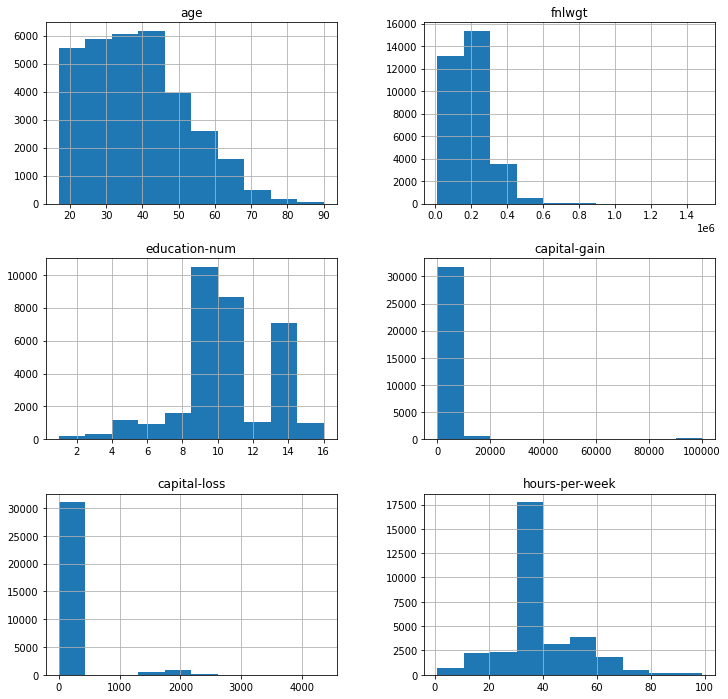

In [ ]:
%matplotlib inline
rcParams['figure.figsize'] = 12, 12
df_train.hist()

As seen from the histograms there are many situations in which the skewness is high and the plot tends to be asymmetrical, this will then be processed later for all the features in such a way as to normalize the distribution and have a more precise prediction.


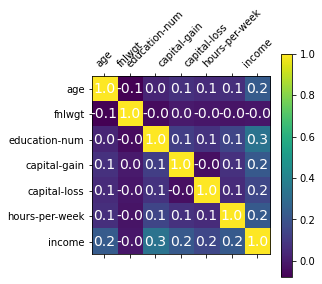

In [ ]:
df_train['income'] = df_train['income'].map({' <=50K':0,' >50K':1})
df_trainsmall=df_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week','income']]
plt.matshow(df_trainsmall.corr())
plt.colorbar()
plt.xticks(np.arange(len(df_trainsmall.corr().columns)), df_trainsmall.corr().columns.values, rotation = 45) 
plt.yticks(np.arange(len(df_trainsmall.corr().columns)), df_trainsmall.corr().columns.values) 
for (i, j), corr in np.ndenumerate(df_trainsmall.corr()):
    plt.text(j, i, '{:0.1f}'.format(corr), ha='center', va='center', color='white', fontsize=14)

fnlwgt feature is highly asymmetrical and for this reason we have chosen not to give it a weight within the prediction of our model.




---


#Data Engineering
Based on our analysis above, we will fill the missing values in our data, and group certain categories logically, to allow our model to learn better.


---



In [ ]:
df_train.drop(['fnlwgt'],axis = 1,inplace = True)
df_train['capital-diff']=df_train['capital-gain']-df_train['capital-loss']
df_train.drop(['capital-loss'],axis = 1,inplace = True)
df_train.drop(['capital-gain'],axis = 1,inplace = True)
#df_train.drop(['education'],axis = 1,inplace = True)
df_train.drop(['education-num'],axis = 1,inplace = True)

df_test.drop(['fnlwgt'],axis = 1,inplace = True)
#df_test.drop(['education'],axis = 1,inplace = True)
df_test.drop(['education-num'],axis = 1,inplace = True)
df_test['capital-diff']=df_test['capital-gain']-df_test['capital-loss']
df_test.drop(['capital-loss'],axis = 1,inplace = True)
df_test.drop(['capital-gain'],axis = 1,inplace = True)

df_test['income'] = df_test['income'].map({' <=50K.':0,' >50K.':1})



---


#Encoding the data

Why we need to encode our data?
Essentially because the majority of the classification models need input as ‘int/float’, and do not work on ‘string’ data.


---



In [ ]:
#Weighted One-Hot: estimation of the weight of each categorical variable to the actual possibility of the income can be <=50K 
categorical = ['workclass','education', 'marital-status', 'occupation', 'relationship','race', 'sex','native-country', 'age', 'hours-per-week', 'capital-diff']
for feature in categorical:
  for value in np.unique(df_train[[feature]].values):
    avg_income = df_train.loc[df_train[feature] == value, 'income'].mean()
    df_train[feature].replace([value],[avg_income],inplace=True)
    df_test[feature].replace([value],[avg_income],inplace=True)
df_test

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-diff
0,0.063020,0.218673,0.051064,0.045961,0.124875,0.013220,0.12388,0.305737,0.213380,0.245835,0,0.185768
1,0.340992,0.218673,0.159509,0.446848,0.115694,0.448571,0.25586,0.305737,0.452643,0.245835,0,0.185768
2,0.137255,0.294792,0.248360,0.446848,0.325116,0.448571,0.25586,0.305737,0.213380,0.245835,1,0.185768
3,0.388122,0.218673,0.190235,0.446848,0.124875,0.448571,0.12388,0.305737,0.213380,0.245835,1,1.000000
4,0.000000,0.104031,0.190235,0.045961,0.103635,0.013220,0.25586,0.109461,0.072237,0.245835,0,0.185768
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,0.340686,0.218673,0.414753,0.104209,0.449034,0.103070,0.25586,0.109461,0.195455,0.245835,0,0.185768
16277,0.254808,0.104031,0.159509,0.085599,0.103635,0.037717,0.12388,0.305737,0.213380,0.245835,0,0.185768
16278,0.340992,0.218673,0.414753,0.446848,0.449034,0.448571,0.25586,0.305737,0.452643,0.245835,0,0.185768
16279,0.388122,0.218673,0.414753,0.104209,0.134483,0.013220,0.26564,0.305737,0.213380,0.245835,0,0.000000




---


#Scaling the data
Feature scaling is a method used to normalize the range of independent variables or features of data since there are certain columns with very small values and some columns with high values.
Feature standardization makes the values of each feature in the data have zero mean and unit variance, this is the main reason why we used StandardScaler.


---



In [ ]:
Y_train = df_train['income']
Y_test = df_test['income']
scaler = StandardScaler()

df_train = pd.DataFrame(scaler.fit_transform(df_train), columns = df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)

X_train = df_train.drop(['income'], axis=1)
X_test = df_test.drop(['income'],axis = 1)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
clf.predict(X_test)

real_predictions = pd.DataFrame(Y_pred,columns=['income'])
real_predictions.to_csv("predictions.test.csv", index=False)

print(f"Metrics comparing '{path_real}' and '{path_predicted}'")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

NameError: ignored



---


#Fitting data into classification models
Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained. A model that is well-fitted produces more accurate outcomes. A model that is overfitted matches the data too closely. A model that is underfitted doesn’t match closely enough.
Why is this a foundamental step?
Model fitting is the essence of machine learning. If a model doesn’t fit data correctly, the outcomes it produces will not be accurate enough to be useful for practical decision-making. A properly fitted model has hyperparameters that capture the complex relationships between known variables and the target variable, allowing it to find relevant insights or make accurate predictions.


---






---


#Logistic Regression
Logistic Regression is a Machine Learning algorithm which is used for the classification problems, it is a predictive analysis algorithm and based on the concept of probability; it uses a cost function that can be defined as the ‘Sigmoid function’ or also known as the ‘logistic function’ instead of a linear function.


---



In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train), 4)
print("Accuracy: " , acc_log)
real_predictions = pd.DataFrame(Y_pred,columns=['income'])
real_predictions.to_csv("predictions.test.csv", index=False)

Accuracy:  0.8692




---


#Support Vector Machine
The machine learning algorithms named support vector machine proposed by Vapnik consist of two important steps. Firstly, the dot product of the data points in the feature space, called kernel, is computed. Secondly, a hyperplan learning algorithm is applied to the kernel.


---



In [ ]:
#Do not run: f1 will decrease (thought accuracy would rise)
svc = SVC()
svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train), 4)
print("Accuracy: " , acc_svc)
print("F1: ", f1_score(Y_test, Y_pred))

Accuracy:  0.8722
F1:  0.6817496229260936




---


#Note:
For our analysis we mainly use the Logistic Regression Algorythm because with SVC the F1 score will decrease even if accuracy goes up, so we decided that F1 high score is more relevant than the accuracy score.
The main reason of this behavior can be found in false negatives; in this case we have an asymmetric DF with 80% 1, and 20% 0. 


---



In [ ]:
col_names = df_train.columns

param=[]
correlation=[]

for c in col_names:
    #Check if binary or continuous
    if c != "income":
        if len(df_train[c].unique()) <= 2:
            corr = spearmanr(df_train['income'],df_train[c])[0]
        else:
            corr = pointbiserialr(df_train['income'],df_train[c])[0]
        param.append(c)
        correlation.append(corr)

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['correlation'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,correlation
parameter,
capital-diff,0.503678
relationship,0.453585
marital-status,0.447404
education,0.368838
occupation,0.351892
age,0.327953
hours-per-week,0.285161
sex,0.215980
workclass,0.179208


This table gives an idea of ​​the correlation between the various features and the fact that the income is higher or less than 50K. As you can see, after various changes to the data, correlations have been obtained, which although not very high, are important because they allow us to understand which are the main variables on which the model will concentrate most of the weight in the predictive phase.


# Compute Metrics

In [ ]:
# Compute Metrics

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def compute_metrics(path_real, path_predicted):

    column_names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income"
    ]
    
    if "test" in path_real:
        df_real = pd.read_csv(path_real, index_col=False, skiprows=1, names=column_names)
    else:
        df_real = pd.read_csv(path_real, index_col=False, names=column_names)
    
    df_pred = pd.read_csv(path_predicted)

    y_real = df_real.income.tolist()
    y_pred = df_pred.income.tolist()

    y_real = [0 if "<=50K" in x else 1 for x in y_real]
    #y_pred = [0 if "<=50K" in x else 1 for x in y_pred]
    

    accuracy = accuracy_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)

    print(f"Metrics comparing '{path_real}' and '{path_predicted}'")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")

In [ ]:
compute_metrics("adult.test", "predictions.test.csv")

Metrics comparing 'adult.test' and 'predictions.test.csv'
Accuracy: 0.8692340765309257
F1: 0.6853849564060884




---


#Bibliography:
(1)https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148<br/>
(2)https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.387.5068&rep=rep1&type=pdf<br/>
(3)https://medium.com/analytics-vidhya/machine-learning-application-census-income-prediction-868227debf12</br>
(4)https://www.datarobot.com/wiki/fitting/</br>
(5)https://www.atoti.io/articles/when-to-perform-a-feature-scaling/


---





---
#Autorship:
Assignement done by:<br/>
Del Chin Riccardo - ID 151930<br/>
Robazza Alberto- ID 152365<br/>
Turchet Andrea - ID 152998<br/>
